In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = './data'

dataframe = pd.read_pickle(os.path.join(DATA_PATH, 'dataframe.pkl'))

In [3]:
"""
Let's print the head of the dataframe to Jupyter to check everything is okay!
"""

dataframe.head()

,document,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### Exploration

In [4]:
"""
We will do some basic exploration of the dataframe.

The goal of this example is to:

1. Demonstrate how to create a custom Keras text classification model.
2. Attempt to train this model in GCP and FloydHub (later!).

Exploration is therefore going to be quick and simple.
"""

'\nWe will do some basic exploration of the dataframe.\n\nThe goal of this example is to:\n\n1. Demonstrate how to create a custom Keras text classification model.\n2. Attempt to train this model in GCP and FloydHub (later!).\n\nExploration is therefore going to be quick and simple.\n'

In [5]:
"""
We have 3000 samples in the dataframe. There are no NULL values.
"""

dataframe.count()

document     1000
sentiment    1000
dtype: int64

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

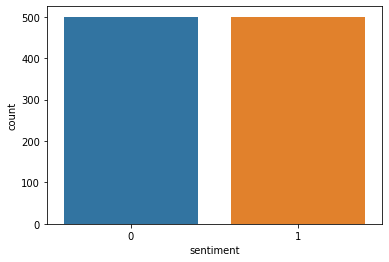

In [7]:
"""
The target variable (sentiment) is perfectly balanced between negative (0) samples and positive (1) samples.

Classification problems usually have some form of class imbalance (e.g. 1 class with more samples than another).

In the case of imbalance you may wish to oversample/undersample to create a more balanced class representation.

"""

sns.countplot(x='sentiment', data=dataframe)
plt.show()

### Splitting

In [8]:
import random
from sklearn.model_selection import train_test_split

RANDOM_STATE = 7

In [9]:
"""
Take the documents from our dataframe and assign them to X.
Take the sentiment from our dataframe and assign them to y.

The .values attribute returns a numpy array rather than a pandas series.
"""

X = dataframe['document'].values
y = dataframe['sentiment'].values

In [10]:
from keras.utils import np_utils

In [11]:
y = np_utils.to_categorical(y)

In [12]:
"""
We want to split our dataframe into a train set and a test set.

We will leave the test set to one side (we don't train on it!) so we can evaluate performance at the end.

We save 10% of our data for the test set (300 samples).
"""

random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=RANDOM_STATE)

In [13]:
"""
We split the train set further into a train set and a validation set.

The validation set will be used when we train the model to check its performance.
"""

random.seed(RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.1,
                                                  random_state=RANDOM_STATE)

In [14]:
"""
We can visually check that the splitting has worked by printing the shape of our resulting dataframes.

We can see that there is still a total of 3000 samples.
"""

X_train.shape, X_val.shape, X_test.shape

((810,), (90,), (100,))

### Preprocess

In [15]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [ ]:
"""
We're now going to do some preprocessing of the data.

We use Tensorflow's Tokenizer:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Consider the document "the cat SAT on the mat."

The default parameters of this Tokenizer do the following:

1. Split the document to a list -> ["the", "cat", "SAT", "on", "the", "mat", "."]
2. Remove punctuation from the texts -> ["the", "cat", "SAT", "on", "the", "mat"]
3. Convert the texts to lowercase -> ["the", "cat", "sat", "on", "the", "mat"]
4. Replace the strings with unique tokens -> [1, 2, 3, 4, 1, 5]
"""

In [17]:
tokenizer = Tokenizer()

In [18]:
tokenizer.fit_on_texts(X)

In [19]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [20]:
"""
Example of the Tokenizer conversion.
"""

print(X_train[0], X_train_tokens[0], sep='\n')

Perfect for the PS3.
[1693, 11, 1, 1694]


In [21]:
"""
We extract the length of our longest document.

When we pass our documents into the neural network - we require they are all the same size.

We will make all the documents the same length (i.e. the length of the longest document).
"""

max_document_len = max([len(doc.split()) for doc in X])

In [22]:
"""
We extract the number of words in our vocabulary (i.e. unique words across all documents).

This is another parameter we will pass into our neural network.
"""

vocab_size = len(tokenizer.word_index) + 1

In [23]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [24]:
"""
Tensorflow has a handy function to make all our documents the same length.

We make all the documents the length of max_document_len by padding them with zeros.

Consider tokenize("the cat sat on the mat.") -> [1, 2, 3, 4, 1, 5] with a max_document_len of 8:

We have an output of [1, 2, 3, 4, 1, 5, 0, 0]
"""

X_train_padded = pad_sequences(X_train_tokens, maxlen=max_document_len, padding='post')
X_val_padded = pad_sequences(X_val_tokens, maxlen=max_document_len, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_document_len, padding='post')

### Modelling

In [25]:
"""
Implement early stopping and model saving here.

Using a patience of 2 so the model most improve within 2 epochs or we stop
training.
"""

'\nImplement early stopping and model saving here.\n\nUsing a patience of 2 so the model most improve within 2 epochs or we stop\ntraining.\n'

In [26]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [27]:
MODEL_PATH = './models'

es = EarlyStopping(monitor='val_binary_accuracy', 
                   patience=2)
mc = ModelCheckpoint(os.path.join(MODEL_PATH, 'lstm_model.h5'),
                     monitor='val_binary_accuracy', 
                     save_best_only=True,
                     verbose=1)

cbs = [es, mc]

In [28]:
embedding_dim = 128

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers.embeddings import Embedding

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_document_len))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dense(2, activation='sigmoid'))

In [32]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

In [33]:
history=model.fit(X_train_padded, 
                  y_train,
                  batch_size=32, 
                  epochs=30,
                  validation_data=(X_val_padded, y_val), 
                  verbose=True, 
                  callbacks=cbs)

Epoch 1/30
26/26 [==============================] - 3s 49ms/step - loss: 0.6944 - binary_accuracy: 0.4650 - val_loss: 0.6934 - val_binary_accuracy: 0.4889

Epoch 00001: val_binary_accuracy improved from -inf to 0.48889, saving model to ./models\lstm_model.h5
Epoch 2/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6930 - binary_accuracy: 0.4991 - val_loss: 0.6909 - val_binary_accuracy: 0.5833

Epoch 00002: val_binary_accuracy improved from 0.48889 to 0.58333, saving model to ./models\lstm_model.h5
Epoch 3/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6114 - binary_accuracy: 0.7272 - val_loss: 0.5324 - val_binary_accuracy: 0.7444

Epoch 00003: val_binary_accuracy improved from 0.58333 to 0.74444, saving model to ./models\lstm_model.h5
Epoch 4/30
26/26 [==============================] - 0s 10ms/step - loss: 0.2574 - binary_accuracy: 0.9256 - val_loss: 0.4119 - val_binary_accuracy: 0.7889

Epoch 00004: val_binary_accuracy improved from 0.74444 to 0.7

In [34]:
from keras.models import load_model

In [35]:
"""
Note I saved the model to the cwd. I manually moved it to /models in case this
notebook was "run all" so we don't lose the saved model. That's why load is 
from /models/ rather than cwd.
"""

saved_model = load_model(os.path.join(MODEL_PATH, 'lstm_model.h5'))

In [36]:
saved_model.evaluate(X_test_padded, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.4231 - binary_accuracy: 0.8300


[0.4230671226978302, 0.8299999833106995]

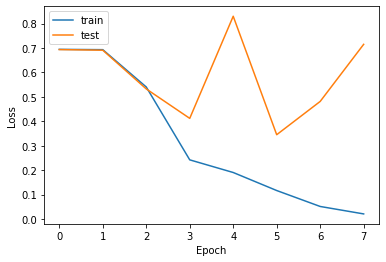

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

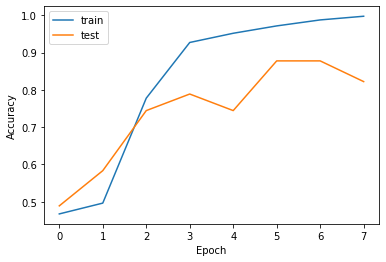

In [38]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import classification_report

In [40]:
predictions = saved_model.predict(X_test_padded)

In [41]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.88      0.83        49
           1       0.87      0.78      0.82        51

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

